In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

from IPython.display import display, Markdown, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 80))

import sys, os, io, time, random, math
import json, base64, requests
import os.path as osp

def _IMPORT_(x):
    try:
        segs = x.split(' ')
        g = globals()
        if 'github.com' in segs[1]:
            uri = segs[1].replace('github.com', 'raw.githubusercontent.com')
            mod = uri.split('/')
            uri = 'https://' + '/'.join(mod[:-1]) + '/main/' + mod[-1] + '.py'
            x = requests.get(uri).text
        elif 'gitee.com' in segs[1]:
            mod = segs[1].split('/')
            uri = 'https://' + '/'.join(mod[:-1]) + '/raw/main/' + mod[-1] + '.py'
            x = requests.get(uri).text
        elif segs[1][0] == '/':
            with open(segs[1] + '.py') as fr:
                x = fr.read()
        exec(x, g)
    except:
        pass

def print_progress_bar(x):
    print('\r', end='')
    print('Progress: {}%:'.format(x), '%s%s' % ('▋'*(x//2), '.'*((100-x)//2)), end='')
    sys.stdout.flush()


CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 8.3.1
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed


In [2]:
###
### Common ###
###

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')

###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly')
_IMPORT_('import plotly.graph_objects as go')
_IMPORT_('import ipywidgets as widgets')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

def show_table(headers, data, width=900):
    ncols = len(headers)
    width = int(width / ncols)
    lralign = []
    caption = []
    for item in headers:
        astr = ''
        if item[0] == ':':
            astr = ':'
            item = item[1:]
        astr += '---'
        if item[-1] == ':':
            astr += ':'
            item = item[:-1]
        lralign.append(astr)
        caption.append(item)
    captionstr = '|'.join(caption) + chr(10)
    lralignstr = '|'.join(lralign) + chr(10)
    imgholdstr = '|'.join(['<img width=%d/>' % width] * ncols) + chr(10)
    table = captionstr + lralignstr + imgholdstr
    is_dict = isinstance(data[0], dict)
    for row in data:
        if is_dict:
            table += '|'.join([f'{row[c]}' for c in caption]) + chr(10)
        else:
            table += '|'.join([f'{col}' for col in row]) + chr(10)
    return Markdown(table)

def show_video(vidsrc, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if vidsrc.startswith('http'):
        data_url = vidsrc
    else:
        mp4 = open(vidsrc, 'rb').read()
        data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(imgsrc, width=None, height=None):
    if isinstance(imgsrc, np.ndarray):
        img = imgsrc
        if width or height:
            if width and height:
                size = (width, height)
            else:
                rate = img.shape[1] / img.shape[0]
                if width:
                    size = (width, int(width/rate))
                else:
                    size = (int(height*rate), height)
            img = cv2.resize(img, size)
            plt.figure(figsize=(3*int(size[0]/80+1), 3*int(size[1]/80+1)), dpi=80)
        plt.axis('off')
        if len(img.shape) > 2:
            plt.imshow(img);
        else:
            plt.imshow(img, cmap='gray');
        return

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if imgsrc.startswith('http'):
        data_url = imgsrc
    else:
        if len(imgsrc) > 2048:
            data_url = 'data:image/jpg;base64,' + imgsrc
        else:
            img = open(imgsrc, 'rb').read()
            data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

def im_read(url, rgb=True, size=None):
    if url.startswith('http'):
        response = requests.get(url)
        if response:
            imgmat = np.frombuffer(response.content, dtype=np.uint8)
            img = cv2.imdecode(imgmat, cv2.IMREAD_COLOR)
        else:
            return None
    else:
        img = cv2.imread(url)
        
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if size:
        if isinstance(size, int):
            size = (size, size)
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img

def img2bytes(x, width=None, height=None):
    if isinstance(x, bytes):
        return x

    if isinstance(x, str):
        if os.path.isfile(x):
            x = PIL.Image.open(x).convert('RGB')
        else:
            import cairosvg
            with io.BytesIO() as fw:
                cairosvg.svg2png(bytestring=x, write_to=fw,
                        output_width=width, output_height=height)
                return fw.getvalue()

    from matplotlib.figure import Figure
    if isinstance(x, Figure):
        with io.BytesIO() as fw:
            plt.savefig(fw)
            return fw.getvalue()

    from torch import Tensor
    from torchvision import transforms
    from PIL import Image
    if isinstance(x, Tensor):
        x = transforms.ToPILImage()(x)
    elif isinstance(x, np.ndarray):
        x = Image.fromarray(x.astype('uint8')).convert('RGB')

    if isinstance(x, Image.Image):
        if width and height:
            x = x.resize((width, height))
        with io.BytesIO() as fw:
            x.save(fw, format='PNG')
            return fw.getvalue()
    raise NotImplementedError(type(x))

def img2b64(x):
    return base64.b64encode(img2bytes(x)).decode()


In [3]:
from k12libs.utils.nb_easy import k12ai_start_html, W3URL
from urllib.parse import urlencode

In [21]:
from PIL import ImageFilter

In [15]:
img = Image.open('/data/datasets/1436.png')

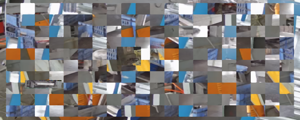

In [19]:
image = img.resize((300, 120))
image.show()

In [48]:
code = '''
import os
import time
from PIL import Image, ImageFilter

image = Image.open('/datasets/1436.png')
image.show()
print('Hello run open pic')
time.sleep(5)
image = image.resize((300, 120))
image.show()
for i in range(10):
    time.sleep(2)
    print('i = %d' % i)
    image = image.rotate(30)
    image.show()
time.sleep(2)
image = image.rotate(30)
image.show()
time.sleep(3)
image = image.filter(ImageFilter.BLUR)
image.show()
'''

In [49]:
params = {'default': code}
k12ai_start_html(f'{W3URL}/codemirror.html?{urlencode(params)}', width='100%', height='1600px')